## Cumm Waste of Energy

In [41]:
import os


for c in ['econome', 'taurus', 'orion', 'graphite']:
    for g in ['1', '2', '3', '4', '5']:
        path = '{}/{}/workloads/'.format(c, g)
        nb = len(os.listdir(path+'train'))
        nb += len(os.listdir(path+'test'))
        print("{} - Group {}: {}".format(c, g, nb))

econome - Group 1: 259
econome - Group 2: 520
econome - Group 3: 504
econome - Group 4: 271
econome - Group 5: 39
taurus - Group 1: 441
taurus - Group 2: 947
taurus - Group 3: 612
taurus - Group 4: 130
taurus - Group 5: 22
orion - Group 1: 659
orion - Group 2: 777
orion - Group 3: 496
orion - Group 4: 129
orion - Group 5: 28
graphite - Group 1: 487
graphite - Group 2: 705
graphite - Group 3: 427
graphite - Group 4: 149
graphite - Group 5: 24


In [112]:
import pandas as pd

def load_benchmark(fn):
    benchmark = pd.read_csv(fn)
    benchmark['workload'] = benchmark['workload'].apply(lambda w: pd.to_datetime(w, format='%Y-%m-%d'))
    benchmark.sort_values(by='workload', inplace=True)
    labels, _ = pd.factorize(benchmark.workload)
    benchmark['day'] = labels
    benchmark.loc[benchmark.policy == 'DeepShutdown', 'policy'] = 'DS'
    benchmark.loc[benchmark.policy == 'OR', 'policy'] = 'OR*'
    benchmark.loc[benchmark.policy == 'Timeout (0)', 'policy'] = 'T(0)'
    benchmark.loc[benchmark.policy == 'Timeout (1)', 'policy'] = 'T(1)'
    benchmark.loc[benchmark.policy == 'Timeout (5)', 'policy'] = 'T(5)'
    return benchmark
    

def load_all_benchmarks(clusters, groups):
    benchmark = None
    for i_c, cluster in enumerate(clusters):
        for i_g, group in enumerate(groups):
            results = load_benchmark("{}/{}/benchmark.csv".format(cluster, group))            
            results['cluster'] = cluster.capitalize()
            results['group'] = "Group {}".format(group)
            if benchmark is None:
                benchmark = results
            else:
                benchmark = pd.concat([benchmark, results], ignore_index=True)
    return benchmark

clusters = ['econome', 'graphite', 'taurus', 'orion']
groups = ['1', '2', '3', '4', '5']

benchmark = load_all_benchmarks(clusters, groups)
#benchmark = benchmark[benchmark.policy != "Random"]
benchmark.reset_index(inplace=True, drop=True)
benchmark.policy.value_counts()

DS        30504
OR*        7626
T(5)       7626
T(0)       7626
T(1)       7626
Random     7626
Name: policy, dtype: int64

In [148]:
policies = ['DS', 'OR*', 'T(0)', 'T(1)', 'T(5)']
metrics = ['mean_qos_delay', 'energy_waste', 'nb_switches', 'mean_stretch']

by='cluster'
x = benchmark[benchmark.policy.isin(policies)].groupby(['cluster', 'group', 'policy', 'day'])[metrics].mean().groupby(['policy']).mean().reset_index()

def foo(f):
    f = f.groupby(['policy'])[metrics].mean().round(2).reset_index()
    for m in metrics:
        ds = f.loc[f['policy'] == 'DS', m].values[0]
        f['diff_{}'.format(m)] = (ds - f[m]) / f[m] * 100
    return f

for m in metrics:
    ds = x.loc[x['policy'] == 'DS', m].values[0]
    x['diff_{}'.format(m)] = (ds - x[m]) / x[m] * 100
x
#x.groupby(by).apply(foo).reset_index()#.to_csv('a2.csv')
#x.apply(foo).reset_index()

,policy,mean_qos_delay,energy_waste,nb_switches,mean_stretch,diff_mean_qos_delay,diff_energy_waste,diff_nb_switches,diff_mean_stretch
0,DS,55.527028,12499.902210,54.886212,0.376446,0.000000,0.000000,0.000000,0.000000
1,OR*,58.250462,11203.896669,52.055337,0.309527,-4.675385,11.567454,5.438203,21.619661
2,T(0),55.311696,14166.998689,66.868739,0.237259,0.389307,-11.767464,-17.919475,58.664860
3,T(1),55.308783,16078.620115,62.690139,0.235552,0.394593,-22.257618,-12.448413,59.814439
4,T(5),55.405692,23244.065041,52.761081,0.232137,0.218996,-46.223252,4.027839,62.165229


/home/d2/anaconda3/envs/drl-gpu/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 18 x 22 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/d2/anaconda3/envs/drl-gpu/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: cumm_energy.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


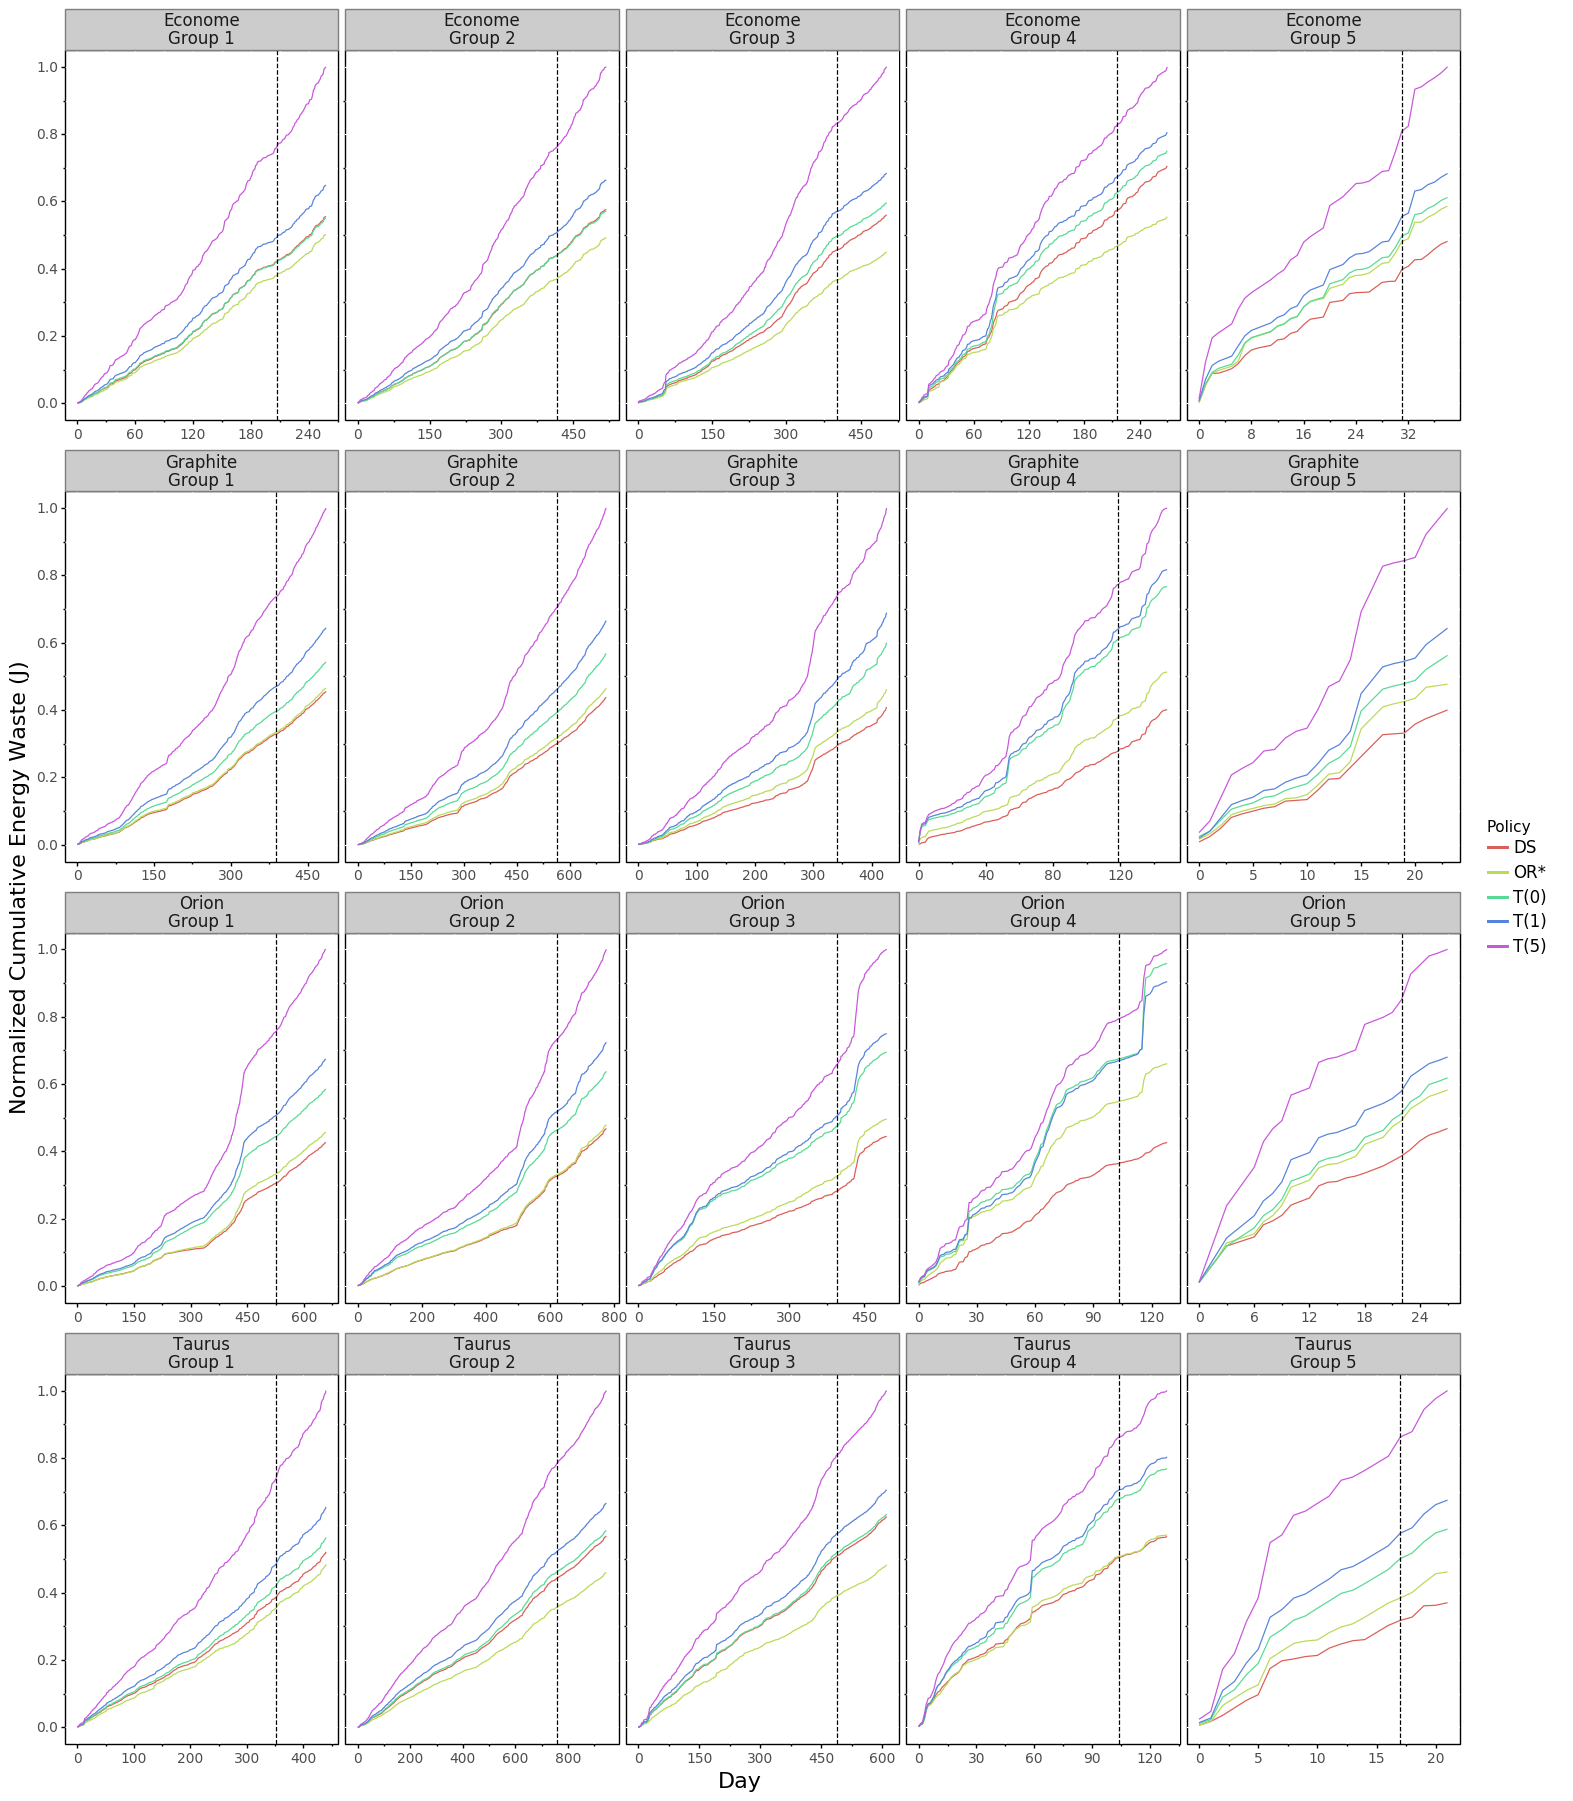

<ggplot: (-9223363266644323240)>

In [15]:
from plotnine import *
from mizani.breaks import mpl_breaks
from mizani.formatters import date_format, custom_format, percent_format

def normalize(dt, max_per_group):
    m = max_per_group[(max_per_group.group == dt['group'].iloc[0]) & (max_per_group.cluster == dt['cluster'].iloc[0])].energy_waste.values[0]
    dt['energy_waste'] /= max(1, m)
    return dt

policies = ['DS', 'OR*', 'T(0)', 'T(1)', 'T(5)']
nb_train = benchmark[(benchmark['train'] == True) & (benchmark['policy'] == 'OR*')].groupby(['cluster', 'group']).score.count().reset_index(name='count')
cumsum = benchmark[benchmark.policy.isin(policies)].groupby(['cluster', 'group', 'policy', 'day']).energy_waste.mean().groupby(['cluster', 'group', 'policy']).cumsum(axis=0).reset_index()
max_per_group = cumsum.groupby(['cluster', 'group']).energy_waste.max().reset_index()
cumsum = cumsum.groupby(['cluster', 'group']).apply(lambda d: normalize(d, max_per_group))

template = theme(
    figure_size = (18, 22), 
    panel_background=element_rect(fill='white', size=0.5),
    panel_border=element_rect(color='black', size=1),
    panel_grid=element_line(color='white'),
    legend_key=element_rect(fill='white', alpha=.3, color='white'),
    legend_text= element_text(size = 12), 
    legend_title_align= 'left',
    axis_text = element_text(size = 10), 
    axis_title = element_text(size = 16), 
    strip_text= element_text(size = 12), 
    panel_spacing_y=.3,
)
p = ggplot(cumsum, aes(x='day', y='energy_waste', color='policy')) + \
    geom_line() + \
    theme_bw() + template + \
    labs(x = 'Day',y = 'Normalized Cumulative Energy Waste (J)',color='Policy') + \
    facet_wrap("~ cluster + group", scales='free_x', ncol=5) + \
    geom_vline(nb_train, aes(xintercept = 'count'), linetype = 'dashed', color = 'black') +\
    scale_x_continuous(breaks=mpl_breaks(symmetric=True))+\
    scale_y_continuous(breaks=mpl_breaks(nbins=6), labels=custom_format('{:.1f}'))

p.save(filename = 'cumm_energy.png')
p

In [73]:
metrics = ['mean_qos_delay', 'energy_waste', 'nb_switches', 'mean_stretch']
def get_best(df):
    a = df.loc[df['energy_waste'] == df['energy_waste'].min(), metrics].mean()
    return df[metrics].mean()
benchmark[benchmark.policy.isin(policies)].groupby(['cluster', 'group', 'policy', 'day']).apply(get_best).groupby(['cluster', 'policy'])[metrics].agg(['mean', 'std', 'min', 'max']).reset_index().round(2)

cluster policy mean_qos_delay                       energy_waste  \
                              mean     std  min      max         mean   
0    Econome     DS          48.50  116.77  0.0  1002.00     21738.40   
1    Econome    OR*          53.16  124.34  0.0  1002.00     18076.86   
2    Econome   T(0)          49.69  123.29  0.0  1002.00     22392.20   
3    Econome   T(1)          49.54  123.24  0.0  1002.00     25483.59   
4    Econome   T(5)          49.48  123.54  0.0  1002.00     36624.22   
5   Graphite     DS          50.92  116.47  0.0   770.00      6712.60   
6   Graphite    OR*          54.27  123.59  0.0   770.00      7216.18   
7   Graphite   T(0)          52.81  125.29  0.0   770.00      8950.24   
8   Graphite   T(1)          52.99  125.43  0.0   770.00     10401.94   
9   Graphite   T(5)          52.91  125.40  0.0   770.00     15434.66   
10     Orion     DS          72.27  132.62  0.0   782.67      6284.59   
11     Orion    OR*          70.34  136.79  0.0   782.67      6763.39   
12     Orion   T(0)          67.23  139.61  0.0   782.67      8996.35   
13     Orion   T(1)          67.14  139.48  0.0   782.67     10081.97   
14     Orion   T(5)          67.39  139.76  0.0   782.67     14104.64   
15    Taurus     DS          48.31  106.29  0.0  1149.00     16513.70   
16    Taurus    OR*          53.60  113.04  0.0  1149.00     13747.39   
17    Taurus   T(0)          49.99  114.82  0.0  1149.00     17441.70   
18    Taurus   T(1)          50.02  114.75  0.0  1149.00     19664.81   
19    Taurus   T(5)          50.23  115.25  0.0  1149.00     28714.38   

                              nb_switches                       mean_stretch  \
         std    min       max        mean     std  min      max         mean   
0   20493.94  125.0  199485.5       93.50   80.38  1.0   797.00         0.22   
1   19474.91  125.0  223416.0       84.96   86.38  1.0  1044.00         0.21   
2   23398.09  250.0  271352.0      106.12  106.36  2.0  1268.00         0.15   
3   25960.63  250.0  329490.0      100.21   97.68  2.0  1260.00         0.15   
4   32931.17  250.0  307125.0       85.35   72.73  2.0   720.00         0.14   
5    6219.47  125.0   51549.5       30.63   27.94  1.0   238.00         0.41   
6    6587.65  125.0   72855.0       33.92   30.36  1.0   340.00         0.30   
7    8287.19  125.0   89024.0       42.20   38.47  1.0   416.00         0.26   
8    9381.74  125.0   87820.0       40.35   35.84  1.0   350.00         0.26   
9   13357.23  125.0   87452.0       34.48   28.82  1.0   208.00         0.25   
10   6930.93  125.0   70165.0       28.07   30.69  1.0   291.25         0.54   
11   7551.15  125.0   67003.0       31.84   34.79  1.0   302.00         0.41   
12   9892.78  250.0  146727.0       42.41   45.92  2.0   687.00         0.30   
13  10864.42  220.0  108591.0       38.95   40.81  1.0   356.00         0.30   
14  15307.39  220.0  125931.0       30.69   33.36  1.0   295.00         0.30   
15  12811.54  125.0  134672.0       72.53   54.15  1.0   584.00         0.30   
16  12307.84  125.0  194121.0       62.43   53.19  1.0   904.00         0.29   
17  14984.53  375.0  264884.0       82.10   68.27  3.0  1236.00         0.22   
18  16836.47  375.0  271768.0       76.56   63.23  3.0  1032.00         0.22   
19  22920.56  375.0  256368.0       65.29   49.51  2.0   612.00         0.22   

                      
     std  min    max  
0   1.03  0.0  26.68  
1   1.07  0.0  26.68  
2   1.00  0.0  26.68  
3   0.99  0.0  26.68  
4   0.99  0.0  26.68  
5   1.38  0.0  22.88  
6   1.39  0.0  29.28  
7   1.41  0.0  29.28  
8   1.40  0.0  29.28  
9   1.41  0.0  29.35  
10  2.10  0.0  66.24  
11  2.04  0.0  63.95  
12  1.47  0.0  34.19  
13  1.47  0.0  34.19  
14  1.47  0.0  34.19  
15  1.48  0.0  28.54  
16  1.46  0.0  29.51  
17  1.45  0.0  29.51  
18  1.44  0.0  28.72  
19  1.44  0.0  29.12

## Jobs Analysis

In [118]:
import pandas as pd
import os
from collections import defaultdict
from plotnine import *

def load_jobs(jobs_dir):
    def read_job_fn(fn):
        jobs = pd.read_csv(fn)[metrics]
        jobs.sort_values(by='submission_time', inplace=True)
        jobs['slowdown'] = (jobs.execution_time + jobs.waiting_time) / jobs.execution_time
        jobs['stretch'] = jobs['waiting_time'] / jobs['requested_time']
        jobs['iatime'] = (jobs['submission_time']-jobs['submission_time'].shift()).fillna(-1)
        return jobs
        
    data = None
    for f in os.listdir(jobs_dir):
        path = os.path.join(jobs_dir, f)
        if not os.path.isdir(path):
            if f[f.find('_')+1: f.rfind('.')] != 'jobs':
                continue
        
            policy = f[: f.find('.')]
            policy = "DS" if policy == 'ds' else policy
            policy = "OR*" if policy == '0' else policy
            policy = "T(0)" if policy == 't0' else policy
            policy = "T(1)" if policy == 't1' else policy
            policy = "T(5)" if policy == 't5' else policy
            #policy = policy.upper()
            jobs = read_job_fn(jobs_dir+f)
            jobs['policy'] = policy
            data = jobs if data is None else pd.concat([data, jobs], ignore_index=True)
        else:
            for job_fn in os.listdir(path):
                fn = os.path.join(path, job_fn)
                if fn[fn.find('_')+1: fn.rfind('.')] != 'jobs':
                    continue
                jobs = read_job_fn(fn)
                policy = fn[: fn.find('.')]
                if policy == 'ds':
                    jobs['policy'] = 'DS'
                elif policy == '0':
                    jobs['policy'] = "OR*"
                elif policy == 't0':
                    jobs['policy'] = "T(0)"
                elif policy == 't1':
                    jobs['policy'] = "T(1)"
                elif fpolicy== 't5':
                    jobs['policy'] = "T(5)"
                else:
                    continue

                data = jobs if data is None else pd.concat([data, jobs], ignore_index=True)
            
    return data

def load_groups(cluster, groups):
    data = None
    for g in groups:
        g_data = load_jobs("{}/{}/jobs/".format(cluster, g))
        g_data['group'] = g
        if data is None:
            data = g_data
        else:
            data = pd.concat([data, g_data], ignore_index=True)
    return data

def load(clusters, groups):
    data = None
    for cluster in clusters:
        c_data = load_groups(cluster, groups)
        c_data['cluster'] = cluster.capitalize()
        if data is None:
            data = c_data
        else:
            data = pd.concat([data, c_data], ignore_index=True)
    return data
    

clusters = ['graphite', 'orion', 'econome', 'taurus']
groups = ['1', '2', '3', '4', '5']

metrics = ['submission_time', 
           'requested_number_of_resources',
          'requested_time',
          'starting_time',
          'execution_time',
          'finish_time',
          'waiting_time',
          'workload_name']

data = load(clusters, groups)
data.submission_time = data.submission_time.astype(float)
data.requested_number_of_resources = data.requested_number_of_resources.astype(float)
data.requested_time = data.requested_time.astype(float)
data.starting_time = data.starting_time.astype(float)
data.execution_time = data.execution_time.astype(float)
data.finish_time = data.finish_time.astype(float)
data.waiting_time = data.waiting_time.astype(float)
data.group = data.group.astype(object)
data.iatime = data.iatime.astype(float)
data.to_csv("jobs.csv", index=False)

KeyboardInterrupt: 

In [119]:
import pandas as pd
data = pd.read_csv("jobs.csv")
data.submission_time = data.submission_time.astype(float)
data.requested_number_of_resources = data.requested_number_of_resources.astype(float)
data.requested_time = data.requested_time.astype(float)
data.starting_time = data.starting_time.astype(float)
data.execution_time = data.execution_time.astype(float)
data.finish_time = data.finish_time.astype(float)
data.waiting_time = data.waiting_time.astype(float)
data.group = data.group.astype(object)
data.iatime = data.iatime.astype(float)

In [121]:
def convert_policy(f):    
    if f[:f.find('.')] == 'ds':
        return 'DS'
    elif f[:f.find('.')] == '0':
        return "OR*"
    elif f[:f.find('.')] == 't0':
        return "T(0)"
    elif f[:f.find('.')] == 't1':
        return "T(1)"
    elif f[:f.find('.')] == 't5':
        return "T(5)"

data.policy = data.policy.apply(convert_policy)

In [122]:
data.policy.value_counts()

T(5)    241087
T(1)    241039
T(0)    240977
DS      234703
OR*     233934
Name: policy, dtype: int64

## Slowdown em relação ao iatime

/home/d2/anaconda3/envs/drl-gpu/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


Grouping...
Ploting...
Saving...


/home/d2/anaconda3/envs/drl-gpu/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/d2/anaconda3/envs/drl-gpu/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: ia_time.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


Showing...


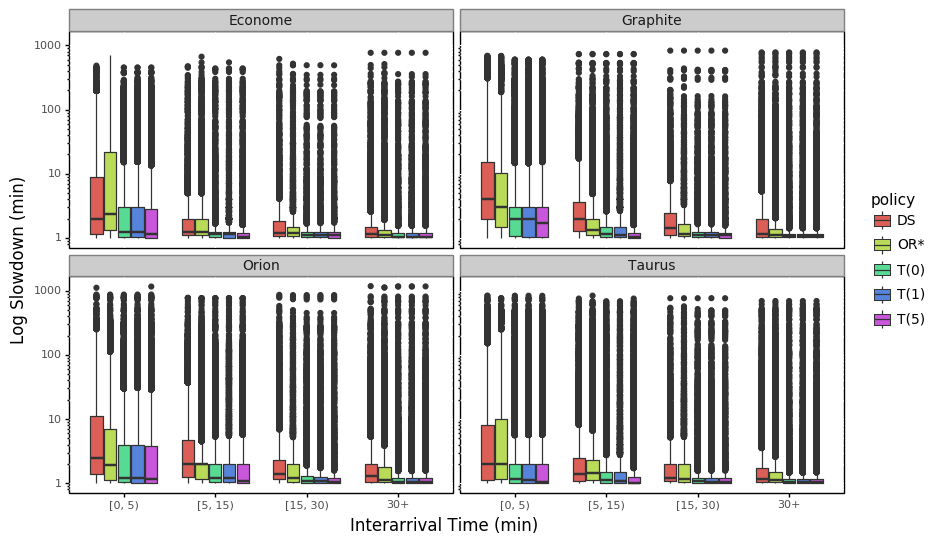

<ggplot: (-9223363297202275363)>

In [132]:
import numpy as np
from tqdm import tqdm
from plotnine import *
from mizani.breaks import mpl_breaks
from mizani.formatters import date_format, custom_format, percent_format

def get_jobs(x):
    #data = data.sort_values(by='iatime', ascending=True)[:1000]
    return x[(x.iatime >=0)]#[x.iatime <= 5].sort_values(by='waiting_time', ascending=True)#[:500]

tqdm.pandas()


print("Grouping...")
x = data.groupby(['cluster', 'group', 'policy'], as_index=False).apply(get_jobs).reset_index(drop=True)
x['iagroup'] = pd.np.digitize(x['iatime'], bins=[0, 5, 15, 30])
x['iagroup'] = x['iagroup'].astype(object)

template = theme(
    figure_size = (10, 6), 
    panel_background=element_rect(fill='white', size=0.5),
    panel_border=element_rect(color='black', size=1),
    panel_grid=element_line(color='white'),
    #axis_line=element_line(),
    legend_key=element_rect(fill='white', alpha=.3, color='white'),
    legend_text= element_text(size = 10), 
    legend_title_align= 'left',
    axis_text = element_text(size = 8), 
    axis_title = element_text(size = 12), 
    strip_text= element_text(size = 10), 
    #panel_grid=element_line(),
)

print("Ploting...")
p = ggplot(x, aes(x='iagroup', y='slowdown', fill='policy')) + \
    geom_boxplot() + scale_y_log10() + \
    scale_x_discrete(labels=['[0, 5)', '[5, 15)', '[15, 30)', '30+'])  + \
    labs(x = 'Interarrival Time (min)',y = 'Log Slowdown (min)')  + \
    theme_bw() + template + facet_wrap("~ cluster", scales='fixed', ncol=2)


print("Saving...")
p.save(filename = 'ia_time.png')

print("Showing...")
p

# Jobs com maior slowdown

100%|██████████| 20/20 [00:00<00:00, 63.10it/s]
/home/d2/anaconda3/envs/drl-gpu/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 6 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/d2/anaconda3/envs/drl-gpu/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: processing_time.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


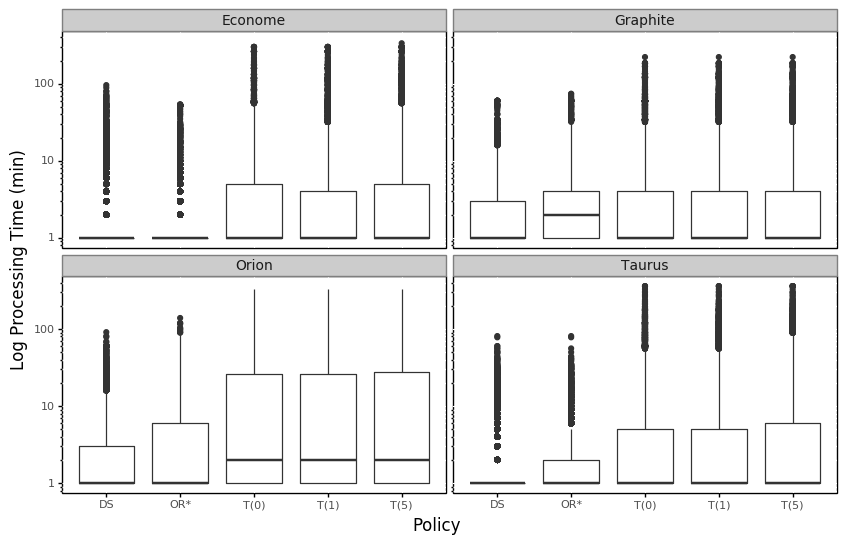

<ggplot: (-9223363297230382343)>

In [142]:
import numpy as np
from plotnine import *
from mizani.breaks import mpl_breaks
from mizani.formatters import date_format, custom_format, percent_format

def get_jobs(x):
    #data = data.sort_values(by='iatime', ascending=True)[:1000]
    return x.sort_values(by='slowdown', ascending=False)[:10000]

x = data.groupby(['cluster', 'policy'], as_index=False).progress_apply(get_jobs).reset_index(drop=True)


p = ggplot(x, aes(x='policy', y='execution_time')) + \
    geom_boxplot() + scale_y_log10() + \
    theme_bw() + template + facet_wrap("~ cluster", scales='fixed', ncol=2) + \
    labs(x = 'Policy',y = 'Log Processing Time (min)')

p.save(filename = 'processing_time.png')
p

In [135]:
x.sort_values(by='slowdown', ascending=False)[:1000]

,submission_time,requested_number_of_resources,requested_time,starting_time,execution_time,finish_time,waiting_time,workload_name,slowdown,stretch,iatime,policy,group,cluster
248771,83.0,12.0,120.0,1263.0,1.0,1264.0,1180.0,2019-01-15,1181.0,9.833333,62.0,DS,3,Orion
258771,83.0,12.0,120.0,1252.0,1.0,1253.0,1169.0,2019-01-15,1170.0,9.741667,62.0,T(0),3,Orion
268771,83.0,12.0,120.0,1252.0,1.0,1253.0,1169.0,2019-01-15,1170.0,9.741667,62.0,T(5),3,Orion
263771,83.0,12.0,120.0,1252.0,1.0,1253.0,1169.0,2019-01-15,1170.0,9.741667,62.0,T(1),3,Orion
268772,151.0,12.0,120.0,1313.0,1.0,1314.0,1162.0,2019-01-15,1163.0,9.683333,0.0,T(5),3,Orion
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359213,579.0,12.0,720.0,1047.0,1.0,1048.0,468.0,2013-02-17,469.0,0.650000,5.0,T(0),3,Taurus
349216,584.0,12.0,720.0,1052.0,1.0,1053.0,468.0,2013-02-17,469.0,0.650000,5.0,DS,3,Taurus
389226,861.0,16.0,120.0,1329.0,1.0,1330.0,468.0,2014-01-30,469.0,3.900000,0.0,T(1),4,Taurus
384236,861.0,16.0,120.0,1329.0,1.0,1330.0,468.0,2014-01-30,469.0,3.900000,0.0,T(0),4,Taurus


# Learning Curve

/home/d2/anaconda3/envs/drl-gpu/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 14 x 8 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/d2/anaconda3/envs/drl-gpu/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: learning_curves.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


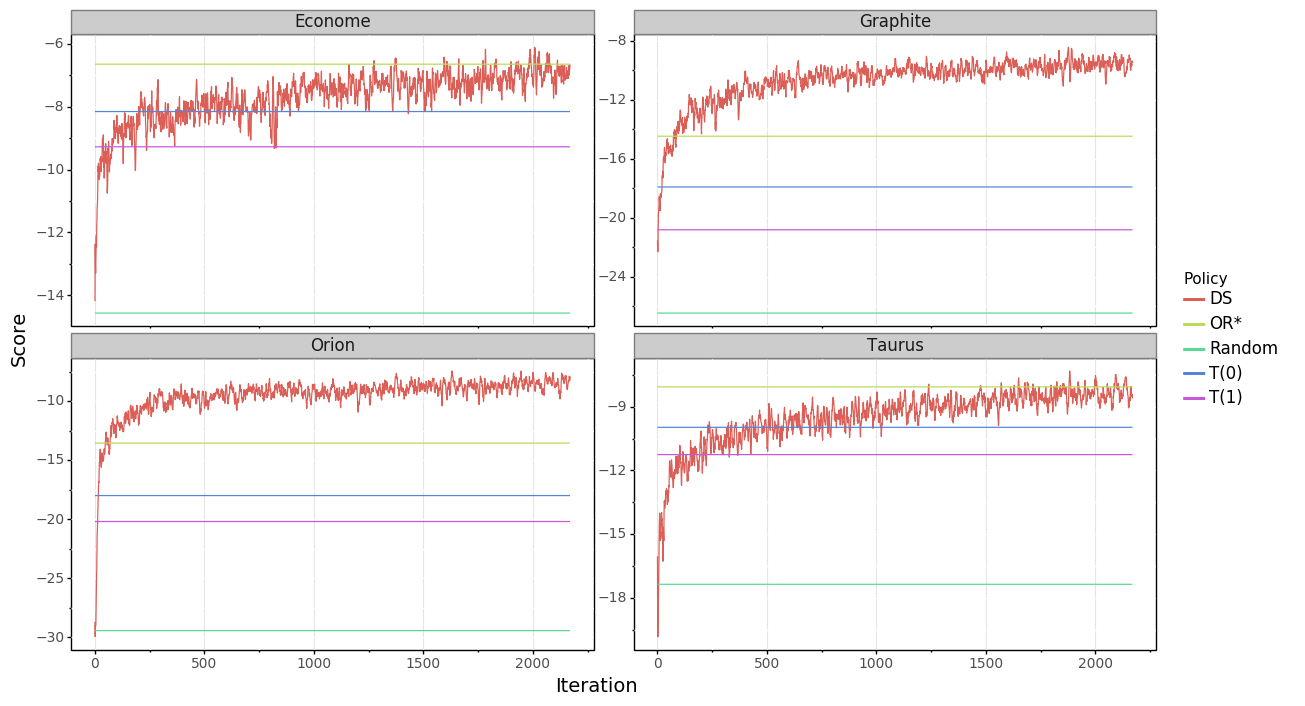

<ggplot: (-9223363297236005828)>

In [37]:
def get_avgs(cluster, groups):
    avgs = None
    for g in groups:
        data = pd.read_csv('{}/{}/benchmark.csv'.format(cluster, g))
        if avgs is None:
            avgs = data
        else:
            avgs = pd.concat([avgs, data], ignore_index=True)        
    return avgs.groupby('policy').score.mean()

def load_logs(cluster, groups):
    logs = None
    for g in groups:
        data = pd.read_csv('{}/{}/log/ppo_log.csv'.format(cluster, g))
        
        if logs is None:
            logs = data
        else:
            logs = pd.concat([logs, data], ignore_index=True)
    
    return logs
        
def load(clusters):
    data = None
    for cluster, groups in clusters.items():
        lr = load_logs(cluster, groups)
        avgs = get_avgs(cluster, groups)
        lr['OR*'] = avgs['OR']
        lr['Random'] = avgs['Random']
        lr['T(0)'] = avgs['Timeout (0)']
        lr['T(1)'] = avgs['Timeout (1)']
        lr['cluster'] = cluster
        if data is None:
            data = lr
        else:
            data = pd.concat([data, lr], ignore_index=True)
    return data
    
    

x = load({
    'econome': ['1','2','3','4','5'],
    'taurus': ['1','2','3','4','5'],
    'graphite': ['1','2','3', '4', '5'],
    'orion': ['1','2','3', '4', '5'],    
})
x = x.groupby(by=['nupdates', 'cluster']).mean().reset_index()
x.cluster = x.cluster.apply(lambda f: f.capitalize())
x['DS'] = x['eprew_avg']
x = pd.melt(x, id_vars=['nupdates', 'cluster'], value_vars=['DS', 'OR*', 'T(0)', 'T(1)', 'Random'], value_name='eprew_avg', var_name='Policy')

template = theme(
    figure_size = (14, 8), 
    panel_background=element_rect(fill='white', size=0.5),
    panel_border=element_rect(color='black', size=1),
   # panel_grid=element_line(color='black'),
    panel_grid_major_x=element_line(),
    panel_grid_minor_x=element_line(color='white'),
    panel_grid_major_y=element_line(color='white'),
    panel_grid_minor_y=element_line(color='white'),
    #axis_line=element_line(),
    legend_key=element_rect(fill='white', alpha=.3, color='white'),
    legend_text= element_text(size = 12), 
    legend_title_align= 'left',
    axis_text = element_text(size = 10), 
    axis_title = element_text(size = 14), 
    strip_text= element_text(size = 12), 
    panel_spacing_x=.4
)

p = ggplot(x, aes(x='nupdates', y='eprew_avg', color='Policy')) + \
    geom_line() + \
    labs(x = 'Iteration',y = 'Score') + theme_bw() + template  + \
    facet_wrap("~ cluster", scales='free_y', ncol=2) +\
    scale_y_continuous(breaks=mpl_breaks(nbins=5))
p.save(filename = 'learning_curves.png')
p

In [43]:


x = load({
    'econome': ['1','2','3','4','5'],
    'taurus': ['1','2','3','4','5'],
    'graphite': ['1','2','3', '4', '5'],
    'orion': ['1','2','3', '4', '5'],    
})
x = x.groupby(by=['nupdates', 'cluster']).mean().reset_index()
x['DS'] = x['eprew_avg']

In [49]:
pd.melt(x, id_vars=['nupdates', 'cluster'], value_vars=['DS', 'OR*', 'T(0)', 'T(1)', 'Random'], value_name='eprew_avg', var_name='policy')


,nupdates,cluster,policy,eprew_avg
0,1,econome,DS,-14.189368
1,1,graphite,DS,-21.539081
2,1,orion,DS,-28.686696
3,1,taurus,DS,-16.048723
4,2,econome,DS,-12.373289
...,...,...,...,...
43395,2169,taurus,Random,-17.365995
43396,2170,econome,Random,-14.566488
43397,2170,graphite,Random,-26.453156
43398,2170,orion,Random,-29.431383
